In [1]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from plotnine import (element_blank, scale_color_manual, scale_x_continuous, ggplot, aes, geom_line ,geom_bar, geom_point, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)

In [2]:
# defin path and load train and test data 
final_data_path = 'final data/'
tr = pd.read_csv(final_data_path + 'train_data_final.csv', index_col = 0)
te = pd.read_csv(final_data_path + 'test_data_final.csv', index_col = 0)
te_dm = xgb.DMatrix(te.drop(['Id'], axis = 1))
gc.collect()

7

In [3]:
# train_x, train_y 
x = tr.drop(['Id', 'Response'], axis = 1)
y = tr['Response']
print(x.shape)
print(y.shape)

(1183747, 55)
(1183747,)


In [5]:
n_fold = 5
kf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 123)

scores = {'fold':[], 'mcc':[], 'g_means':[], 'auc_scores':[], 'f1_scores':[], 'threshold':[]}

evals_result = {}
loss_data = pd.DataFrame()
predictions = np.zeros(len(te))

num_round = 23
params = {
        #   'colsample_bytree':0.8, 
        #   'eta':0.1, # 0.1
        #   'max_depth': 12,
        #   'subsample': 0.9,
        #   'min_child_weight': 15, 
          'objective': 'binary:logistic',
          'seed': 123,
          'disable_default_eval_metric': 1
            }

for fold_i, (tr_idx, va_idx) in enumerate(kf.split(x, y)):
    
    temp_loss_data = pd.DataFrame()

    tr_x, va_x = x.iloc[tr_idx], x.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, 
                      num_round, 
                      evals = watchlist, 
                      verbose_eval=1, 
                      early_stopping_rounds=30, 
                      evals_result=evals_result,
                      feval = u.evalerror
                      )
    
    va_pred = model.predict(dvalid)
    
    # prediction
    prediction = model.predict(te_dm)
    predictions += prediction

    if (fold_i + 1 )== n_fold:
        predictions /= (fold_i + 1)
    
    # best threshold and MCC
    best_thresh, mcc_value= u.best_thr_mcc(va_pred, dvalid)
    y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

    # gmeans, f1 score, auc
    tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
    spec = tn / (tn+fp)
    sens = tp / (tp + fn)
    g_means = np.sqrt(spec * sens)
    fmeasure = f1_score(va_y, y_pred)
    auc_score = roc_auc_score(va_y, y_pred)

    # data fo loss vs tree
    temp_loss_data = pd.DataFrame({'train': list(evals_result['train'].values())[0],
                                   'test': list(evals_result['eval'].values())[0],
                                   'tree': [i+1 for i in range(len(list(evals_result['train'].values())[0]))]})

    print('mcc value: {}'.format(round(mcc_value, 3)))
    print('g_means value: {}'.format(round(g_means, 3)))
    print('auc value: {}'.format(round(auc_score, 3)))
    print('f1_score value: {}'.format(round(fmeasure, 3)))
    print('threshold: {}'.format(round(best_thresh, 3)))
    
    # wrap loss_data and scores
    loss_data = pd.concat([loss_data, temp_loss_data], axis = 0).reset_index(drop=True)
    scores['fold'].append(fold_i + 1)
    scores['mcc'].append(mcc_value)
    scores['g_means'].append(g_means)
    scores['f1_scores'].append(fmeasure)
    scores['auc_scores'].append(auc_score)
    scores['threshold'].append(best_thresh)
    
    gc.collect()


[0]	train-error:-0.37553	eval-error:-0.36717
[1]	train-error:-0.39882	eval-error:-0.37663
[2]	train-error:-0.39950	eval-error:-0.37968
[3]	train-error:-0.40118	eval-error:-0.37837
[4]	train-error:-0.39950	eval-error:-0.38169
[5]	train-error:-0.40174	eval-error:-0.37887
[6]	train-error:-0.40163	eval-error:-0.38323
[7]	train-error:-0.40030	eval-error:-0.38171
[8]	train-error:-0.40130	eval-error:-0.38546
[9]	train-error:-0.39620	eval-error:-0.38063
[10]	train-error:-0.39958	eval-error:-0.38185
[11]	train-error:-0.40584	eval-error:-0.38745
[12]	train-error:-0.40626	eval-error:-0.38852
[13]	train-error:-0.40814	eval-error:-0.39128
[14]	train-error:-0.40876	eval-error:-0.39234
[15]	train-error:-0.41039	eval-error:-0.39220
[16]	train-error:-0.42223	eval-error:-0.40077
[17]	train-error:-0.42140	eval-error:-0.40077
[18]	train-error:-0.42223	eval-error:-0.40285
[19]	train-error:-0.42261	eval-error:-0.40270
[20]	train-error:-0.42330	eval-error:-0.40033
[21]	train-error:-0.42420	eval-error:-0.4021

In [8]:
pd.DataFrame(scores)

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.439894,0.518397,0.634150,0.392365,0.300000
1,2,0.428675,0.505637,0.627622,0.378088,0.335714
2,3,0.432373,0.477806,0.614039,0.357631,0.407143
3,4,0.467397,0.539688,0.645436,0.420556,0.300000
4,5,0.425098,0.471508,0.611047,0.349714,0.407143


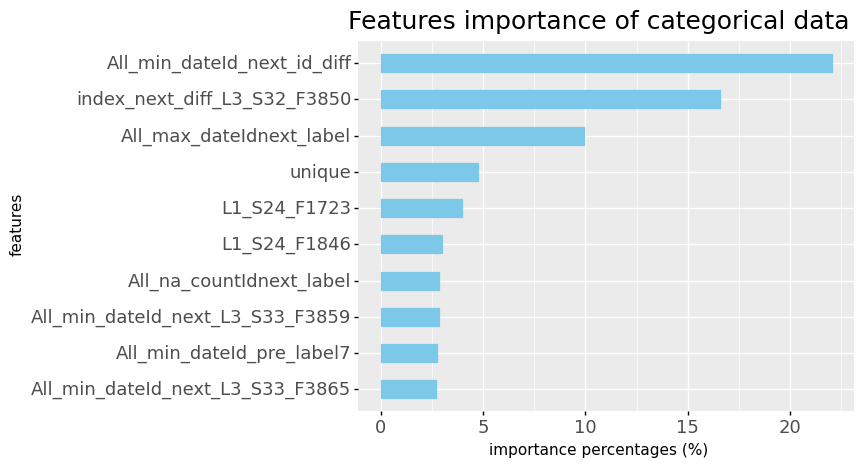

<ggplot: (-9223371854308370756)>

In [6]:
# model = xgb.Booster()
# model.load_model(path + "baseline (xgboost)_model.json")
fscore = model.get_score(importance_type = 'gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))

g = (
    ggplot(feat_imp.iloc[-10:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = range(0, 100, 5))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of categorical data')
)
# ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

c:\py_venv\tutorial-venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


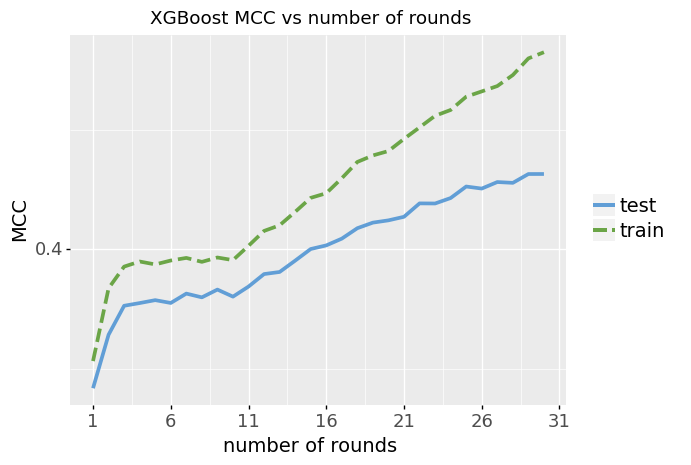

<ggplot: (-9223371854306222840)>

In [7]:
loss_data[['train', 'test']] = loss_data[['train', 'test']] * -1
loss_data = loss_data.groupby('tree')['train', 'test'].mean().reset_index()
loss_data = pd.melt(loss_data, id_vars = ['tree'], value_vars = ['train', 'test'])
loss_data['variable'] = loss_data['variable'].astype('category')

g = (ggplot(loss_data, aes(x = 'tree', y = 'value', group = 'variable', color = 'variable', linetype = 'variable')) 
     + geom_line(size = 1.5)
    #  + geom_smooth(method = 'lm') 
     + theme(axis_text_x = element_text(size = 13),
             axis_text_y = element_text(size = 13),
             axis_title = element_text(size = 14),
             legend_text = element_text(size = 14),
             legend_title = element_blank())
     + scale_x_continuous(breaks = range(1, 76, 5))
     + scale_y_continuous(breaks = np.linspace(0, 1.0, 21, endpoint = True))
     + scale_color_manual(values=["#619ED6", "#6BA547"])
     + labs(x = 'number of rounds', y = 'MCC')
     + ggtitle('XGBoost MCC vs number of rounds')
    )
g

In [9]:
path = 'model/1.baseline (xgboost)/'

pd.DataFrame(scores).to_csv(path + 'baseline (xgboost)_scores.csv', index = False)
loss_data.to_csv(path + 'baseline (xgboost)_loss_data.csv', index = False)
model.save_model(path + "baseline (xgboost)_model.json")

# private: 
submission = pd.DataFrame({'Id': te['Id'], 'Response': predictions > np.mean(scores['threshold'])})
submission['Response'] = submission['Response'].astype('int')
submission.to_csv(path + 'submission_baseline (xgboost).csv', index = 0)